# Scraping Laptops data from BestBuy Canada website

**Updated for Selenium-based scraping with modular architecture**
This is an example of data scraping from BestBuy Canada website. This notebook demonstrates how to use the refactored webscraping project with Selenium WebDriver to handle JavaScript-rendered content.

This exercise helps in deciding what computer to buy for data science projects by analyzing laptop data from BestBuy. We use Selenium WebDriver to interact with the website and automatically collect data about laptops from the dynamic React-based website.

After getting the CSV file, we clean it, examine descriptive statistics, and create visualizations.

## New Project Structure

The project has been reorganized into:
- **src/** - All Python modules (config, scraper_selenium, data_cleaner, visualizer, logger)
- **data/** - CSV data files
- **notebooks/** - This tutorial notebook
- **docs/** - Documentation

## Setup: Import Required Libraries and Modules

In [1]:
!pip install seaborn

In [2]:
# Standard library imports
import sys
from pathlib import Path

# Add parent directory to path to import from src/
sys.path.insert(0, str(Path.cwd().parent))

# External library imports
import pandas as pd
import matplotlib.pyplot as plt

# Project module imports
from src.logger import logger
from src.config import get_config, build_url
from src.scraper_selenium import BestBuySeleniumScraper, scrape_all_laptops
from src.data_cleaner import save_data, load_and_process_data, clean_price, clean_votes
from src.visualizer import visualize_data, create_histograms, create_boxplots

%matplotlib inline

## Using the Logger

The project now uses **Loguru** for professional logging instead of print statements.

In [3]:
# Demonstrate logging
logger.info("Starting laptop data analysis tutorial with Selenium")
logger.debug("This is a debug message")
logger.warning("This is a warning message")
logger.success("Logger is working correctly!")

2025-12-10 13:26:59 | INFO     | __main__:<module>:2 - Starting laptop data analysis tutorial with Selenium
2025-12-10 13:26:59 | WARNING  | __main__:<module>:4 - This is a warning message
2025-12-10 13:26:59 | SUCCESS  | __main__:<module>:5 - Logger is working correctly!


## Configuration

Load the scraping configuration from the config module.

In [4]:
# Get configuration
config = get_config()
logger.info(f"Configuration loaded: {len(config['pages'])} pages, {len(config['ram_sizes'])} RAM sizes")
print(f"Pages to scrape: {config['pages'][:5]}...")  # Show first 5
print(f"RAM sizes: {config['ram_sizes']}")
print(f"Output file: {config['output_file']}")

2025-12-10 13:26:59 | INFO     | __main__:<module>:3 - Configuration loaded: 20 pages, 3 RAM sizes
Pages to scrape: ['1', '2', '3', '4', '5']...
RAM sizes: ['8', '12', '32']
Output file: data/laptops_bestbuy_2025.csv


## Why Selenium?

Best Buy Canada's website is built with React and loads content dynamically using JavaScript. Traditional HTTP requests (like `requests` library) only get the initial HTML, which doesn't contain the product data. We need Selenium WebDriver to:

1. Open a real browser (Chrome)
2. Wait for JavaScript to execute
3. Let React render the product components
4. Extract the fully-rendered HTML

In [5]:
# Build a test URL
test_url = build_url('1', '8')
logger.info(f"Test URL: {test_url}")

# Create a scraper instance (use headless=False to see the browser in action)
scraper = BestBuySeleniumScraper(config, headless=True)

try:
    # Setup the driver
    if scraper.setup_driver():
        logger.success("WebDriver initialized successfully!")
        
        # Load the page
        scraper.driver.get(test_url)
        logger.info("Page loaded, waiting for products...")
        
        # Wait for products to load
        if scraper.wait_for_products(timeout=15):
            logger.success("Products detected on page!")
            
            # Get containers
            from bs4 import BeautifulSoup
            page_source = scraper.driver.page_source
            soup = BeautifulSoup(page_source, 'html.parser')
            containers = soup.find_all('div', {'itemtype': lambda x: x and 'Product' in x})
            
            logger.info(f"Found {len(containers)} product containers")
            
            # Try to extract first product
            if containers:
                first_product = scraper.extract_laptop_data(containers[0])
                if first_product:
                    logger.success("Successfully extracted first product:")
                    for key, value in first_product.items():
                        print(f"  {key}: {value}")
                else:
                    logger.warning("Could not extract data from first container")
        else:
            logger.error("Products did not load in time")
            
finally:
    # Always close the driver
    scraper.close_driver()

2025-12-10 13:26:59 | INFO     | __main__:<module>:3 - Test URL: https://www.bestbuy.ca/en-ca/category/windows-laptops/36711?page=1&path=category%3AComputers%2B%2526%2BTablets%3Bcategory%3ALaptops%2B%2526%2BMacBooks%3Bcategory%3AWindows%2BLaptops%3Bcustom0ramsize%3A8
2025-12-10 13:26:59 | INFO     | src.scraper_selenium:setup_driver:44 - Setting up Chrome WebDriver...
2025-12-10 13:26:59 | INFO     | src.scraper_selenium:setup_driver:51 - Running in headless mode (no browser window)
2025-12-10 13:26:59 | SUCCESS  | src.scraper_selenium:setup_driver:84 - Chrome WebDriver initialized successfully
2025-12-10 13:26:59 | SUCCESS  | __main__:<module>:11 - WebDriver initialized successfully!
2025-12-10 13:27:09 | INFO     | __main__:<module>:15 - Page loaded, waiting for products...
2025-12-10 13:27:09 | SUCCESS  | __main__:<module>:19 - Products detected on page!
2025-12-10 13:27:10 | INFO     | __main__:<module>:27 - Found 24 product containers
2025-12-10 13:27:10 | SUCCESS  | __main__:<mod

## Extract Data from First Laptop

Let's examine the first laptop container to understand the data structure.

## Option 1: Run Full Scraper

**Warning:** This will make many requests and may take a long time. Consider using existing data instead.

In [6]:
# UNCOMMENT TO RUN FULL SCRAPING (can take 20-30 minutes)
# logger.info("Starting full Selenium web scraping...")
# data = scrape_all_laptops(config, build_url)
# logger.success(f"Scraping complete! Collected {len(data['names'])} laptops")
#
# # Save the data
# output_path = config['output_file']
# df = save_data(data, output_path)
# logger.success(f"Data saved to {output_path}")

## Option 2: Load Existing Data

Let's use the existing scraped data from the data/ directory.

In [7]:
# Load existing data
# Try the 2025 data first, fall back to 2019 data if not available
import os
data_files = [
    '../data/laptops_bestbuy_2025.csv',
    '../data/laptops_rating2019.csv',
    '../data/laptops_rating.csv'
]

df_raw = None
data_file = None

for file in data_files:
    if os.path.exists(file):
        data_file = file
        logger.info(f"Loading data from {data_file}")
        try:
            df_raw = pd.read_csv(data_file)
            logger.success(f"Data loaded successfully! Shape: {df_raw.shape}")
            break
        except Exception as e:
            logger.error(f"Error loading {file}: {e}")
            continue

if df_raw is None:
    logger.error("No data file found! Please run the scraper first or check data directory.")
else:
    display(df_raw.head())

2025-12-10 13:27:10 | INFO     | __main__:<module>:16 - Loading data from ../data/laptops_bestbuy_2025.csv
2025-12-10 13:27:10 | SUCCESS  | __main__:<module>:19 - Data loaded successfully! Shape: (1139, 5)


,Unnamed: 0,laptops,prices,ratings,votes
0,0,"Dell Inspiron 15 15.6"" Touchscreen Laptop (Int...",$500.39,4.64,505
1,1,"ASUS Vivobook Go 15 15.6"" Laptop - Mixed Black...",$400.37,4.13,23
2,2,"Acer Aspire Lite 15.6"" Laptop - Silver (Intel ...",$350.39,4.29,7
3,3,"Lenovo IdeaPad Slim 3i 15.3"" Laptop - Luna Gre...",$450.39,4.82,11
4,4,"Acer Aspire Go 15.6"" Laptop - Iron (Intel Core...",$500.39,4.40,5


## Data Cleaning

Use the data_cleaner module to process the raw data.

In [8]:
# Example: Clean a single price
sample_price = '$1,234.56'
cleaned_price = clean_price(sample_price)
logger.info(f"Price cleaning example: '{sample_price}' -> {cleaned_price}")

# Example: Clean a vote count
sample_vote = '(123)'
cleaned_vote = clean_votes(sample_vote)
logger.info(f"Vote cleaning example: '{sample_vote}' -> {cleaned_vote}")

2025-12-10 13:27:10 | INFO     | __main__:<module>:4 - Price cleaning example: '$1,234.56' -> 1234.56
2025-12-10 13:27:10 | INFO     | __main__:<module>:9 - Vote cleaning example: '(123)' -> 123.0


In [9]:
# Clean the entire dataframe
logger.info("Cleaning dataframe...")
df_clean = load_and_process_data(data_file)
logger.success("Data cleaning complete!")

# Display cleaned data info
print("\nCleaned Data Info:")
df_clean.info()

2025-12-10 13:27:10 | INFO     | __main__:<module>:2 - Cleaning dataframe...
2025-12-10 13:27:10 | SUCCESS  | __main__:<module>:4 - Data cleaning complete!

Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1139 entries, 0 to 1138
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1139 non-null   int64  
 1   laptops     1139 non-null   object 
 2   prices      1139 non-null   float64
 3   ratings     1139 non-null   float64
 4   votes       1139 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 44.6+ KB


In [10]:
# Display first few rows
df_clean.head()

,Unnamed: 0,laptops,prices,ratings,votes
0,0,"Dell Inspiron 15 15.6"" Touchscreen Laptop (Int...",500.39,4.64,505.0
1,1,"ASUS Vivobook Go 15 15.6"" Laptop - Mixed Black...",400.37,4.13,23.0
2,2,"Acer Aspire Lite 15.6"" Laptop - Silver (Intel ...",350.39,4.29,7.0
3,3,"Lenovo IdeaPad Slim 3i 15.3"" Laptop - Luna Gre...",450.39,4.82,11.0
4,4,"Acer Aspire Go 15.6"" Laptop - Iron (Intel Core...",500.39,4.40,5.0


## Descriptive Statistics

In [11]:
logger.info("Computing descriptive statistics...")
stats = df_clean[['prices', 'ratings', 'votes']].describe()
print("\nDescriptive Statistics:")
print(stats)

2025-12-10 13:27:10 | INFO     | __main__:<module>:1 - Computing descriptive statistics...

Descriptive Statistics:
            prices      ratings        votes
count  1139.000000  1139.000000  1139.000000
mean    957.302239     0.698191    20.937665
std     683.559355     1.591392   166.426233
min     157.890000     0.000000     0.000000
25%     489.000000     0.000000     0.000000
50%     789.600000     0.000000     0.000000
75%    1200.380000     0.000000     0.000000
max    6499.400000     5.000000  2591.000000


## Find Interesting Insights

In [12]:
# Find laptop with most votes
max_votes_idx = df_clean['votes'].idxmax()
most_voted = df_clean.loc[max_votes_idx]
logger.info(f"Most voted laptop: {most_voted['laptops']} with {most_voted['votes']} votes")
print(f"\nMost Voted Laptop:")
print(f"  Name: {most_voted['laptops']}")
print(f"  Price: ${most_voted['prices']:.2f}")
print(f"  Rating: {most_voted['ratings']}%")
print(f"  Votes: {most_voted['votes']:.0f}")

2025-12-10 13:27:10 | INFO     | __main__:<module>:4 - Most voted laptop: HP - 15.6" Touch-Screen Laptop - Intel Core 6-Core i3 -1215u - 8GB RAM- 256GB SSD - Natural Silver, Intel UHD Graphics, Windows 11 Home S mode, HDMI 1,4b, WIFI 5 with 2591.0 votes

Most Voted Laptop:
  Name: HP - 15.6" Touch-Screen Laptop - Intel Core 6-Core i3 -1215u - 8GB RAM- 256GB SSD - Natural Silver, Intel UHD Graphics, Windows 11 Home S mode, HDMI 1,4b, WIFI 5
  Price: $509.99
  Rating: 4.69%
  Votes: 2591


In [13]:
# Find laptops with perfect rating (100%)
perfect_ratings = df_clean[df_clean['ratings'] == 100.0]
logger.info(f"Found {len(perfect_ratings)} laptops with 100% rating")
if len(perfect_ratings) > 0:
    print("\nLaptops with 100% rating:")
    print(perfect_ratings[['laptops', 'prices', 'votes']].head())

2025-12-10 13:27:10 | INFO     | __main__:<module>:3 - Found 0 laptops with 100% rating


## Data Visualization

Use the visualizer module to create charts.

2025-12-10 13:27:10 | INFO     | __main__:<module>:2 - Creating histograms...


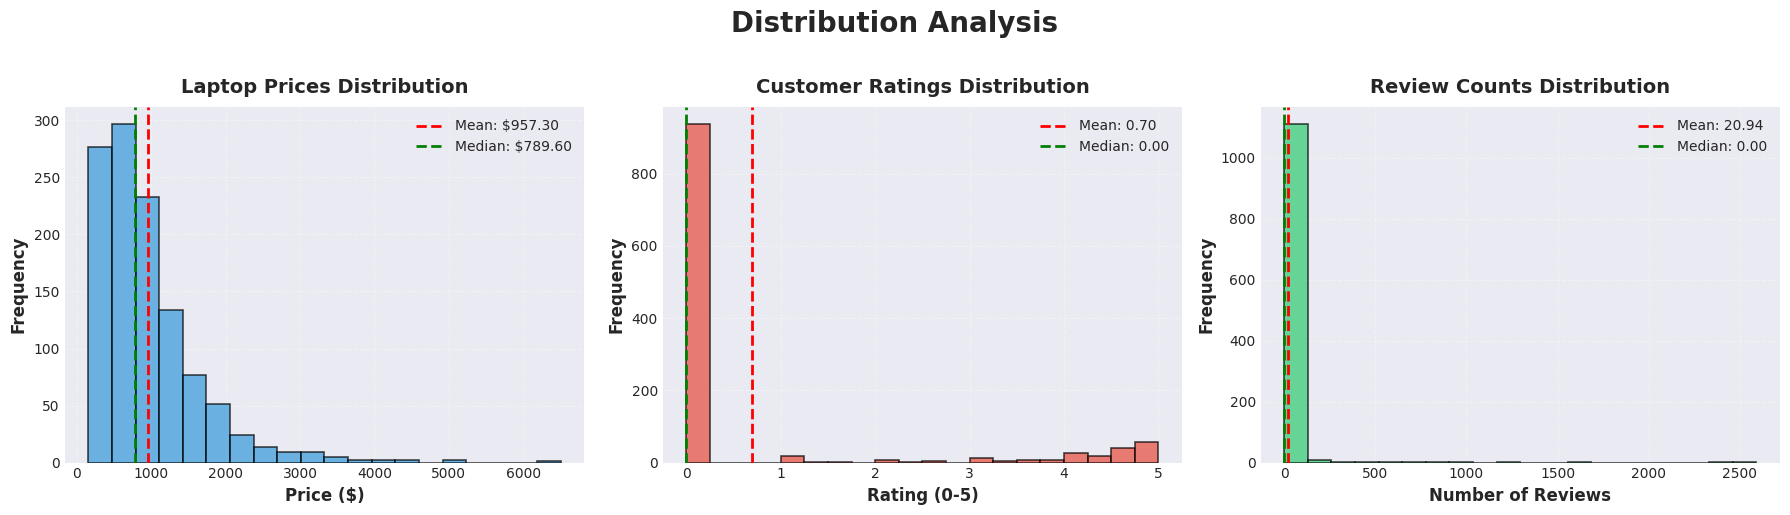

In [14]:
# Create histograms
logger.info("Creating histograms...")
create_histograms(df_clean)

2025-12-10 13:27:10 | INFO     | __main__:<module>:2 - Creating boxplots...


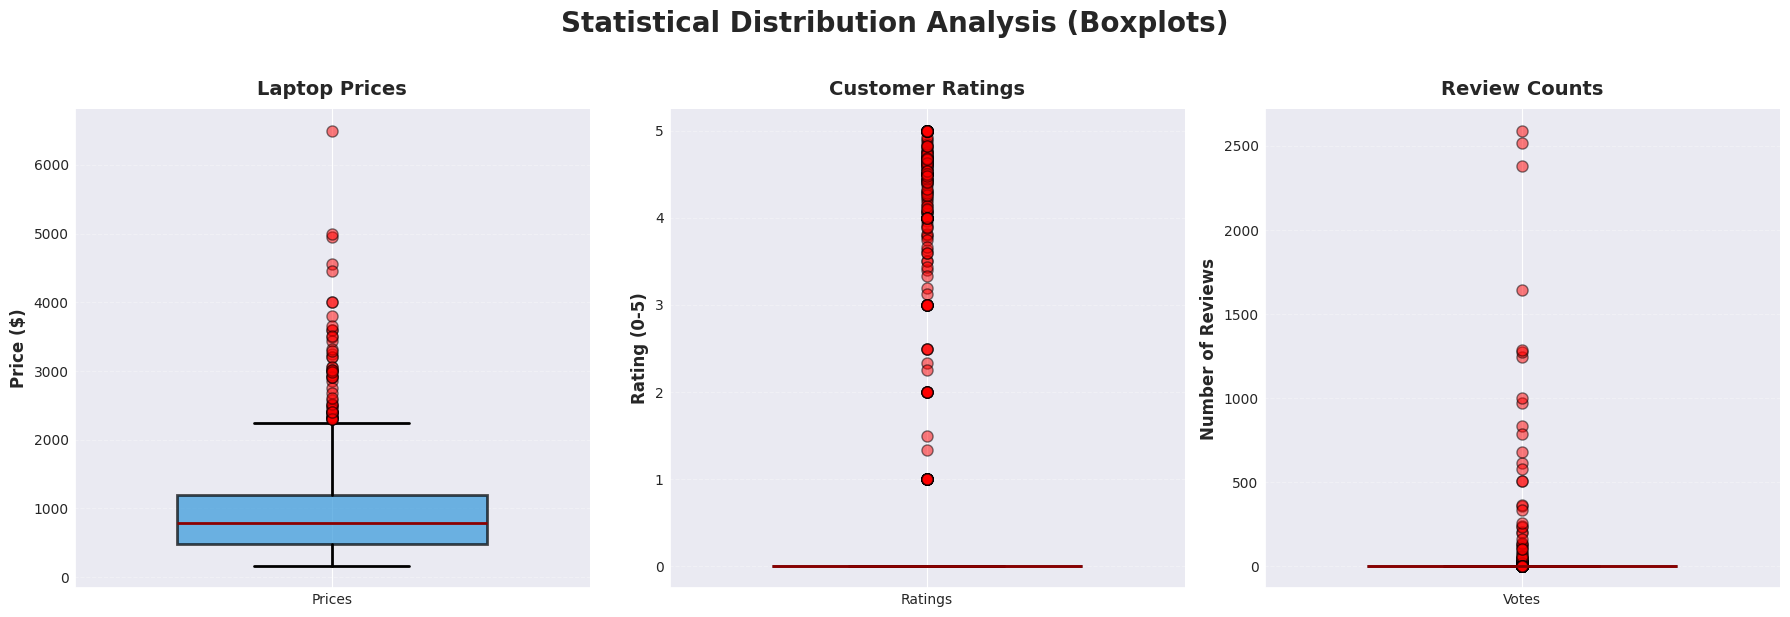

In [15]:
# Create boxplots
logger.info("Creating boxplots...")
create_boxplots(df_clean)

## Complete Visualization Pipeline

2025-12-10 13:27:11 | INFO     | __main__:<module>:2 - Running complete visualization pipeline...
2025-12-10 13:27:11 | INFO     | src.visualizer:visualize_data:249 - ====================================================================================================
2025-12-10 13:27:11 | INFO     | src.visualizer:visualize_data:250 - 📊 CREATING BEAUTIFUL VISUALIZATIONS...
2025-12-10 13:27:11 | INFO     | src.visualizer:visualize_data:251 - ====================================================================================================
2025-12-10 13:27:11 | INFO     | src.visualizer:visualize_data:252 - Descriptive statistic measures of the data
2025-12-10 13:27:11 | INFO     | src.visualizer:visualize_data:253 - 
            prices      ratings        votes
count  1139.000000  1139.000000  1139.000000
mean    957.302239     0.698191    20.937665
std     683.559355     1.591392   166.426233
min     157.890000     0.000000     0.000000
25%     489.000000     0.000000     0.000000
50

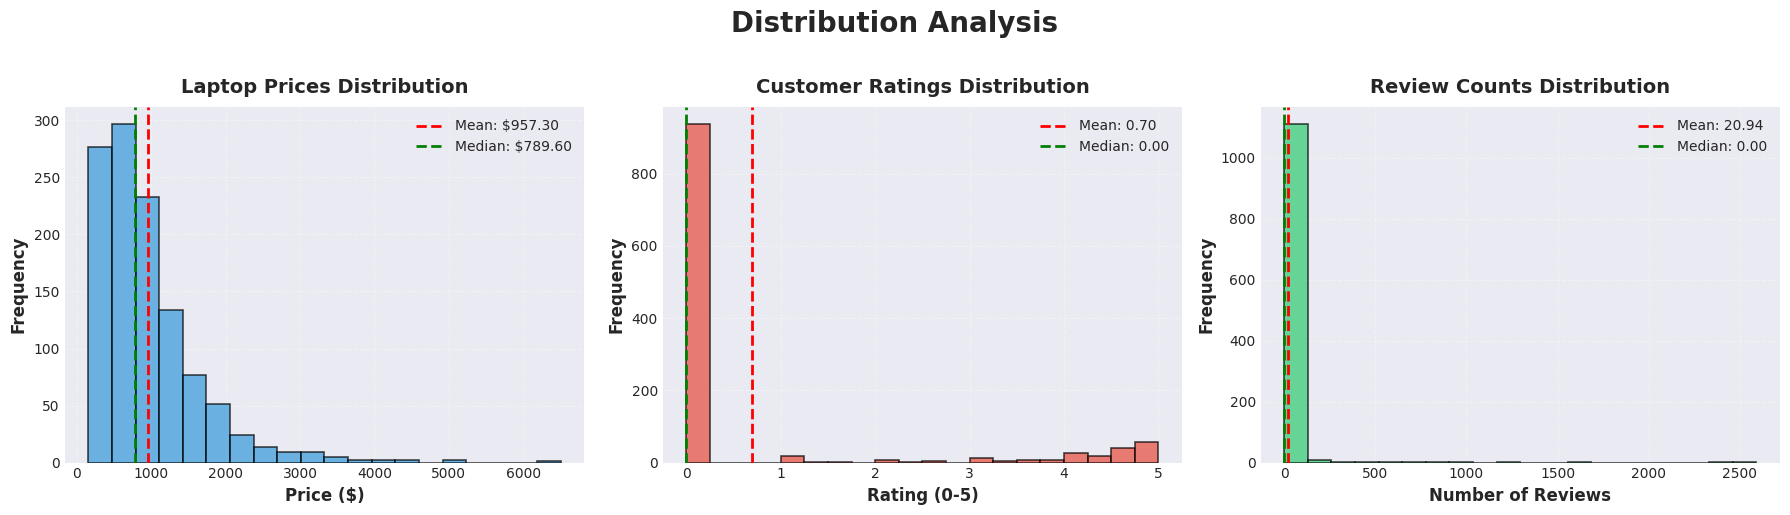

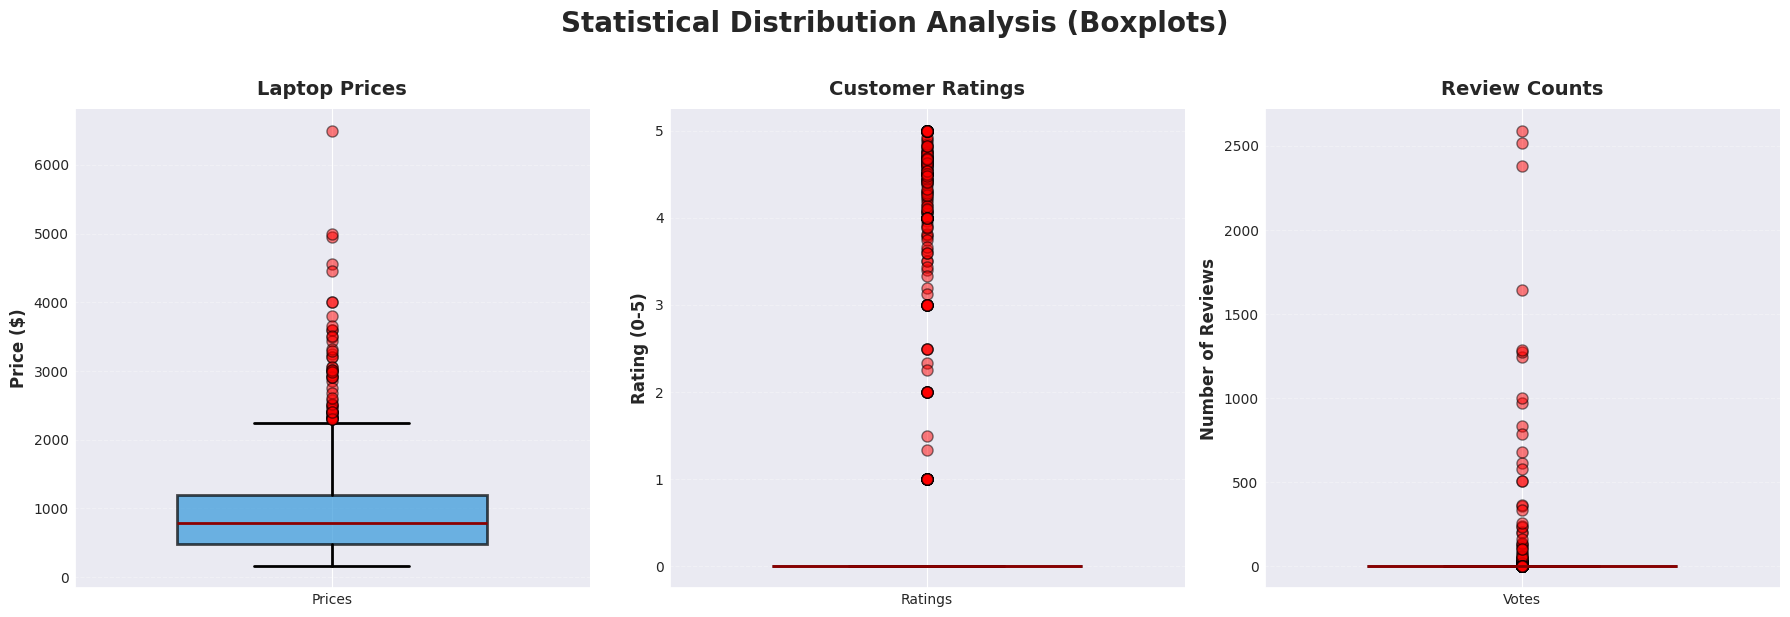

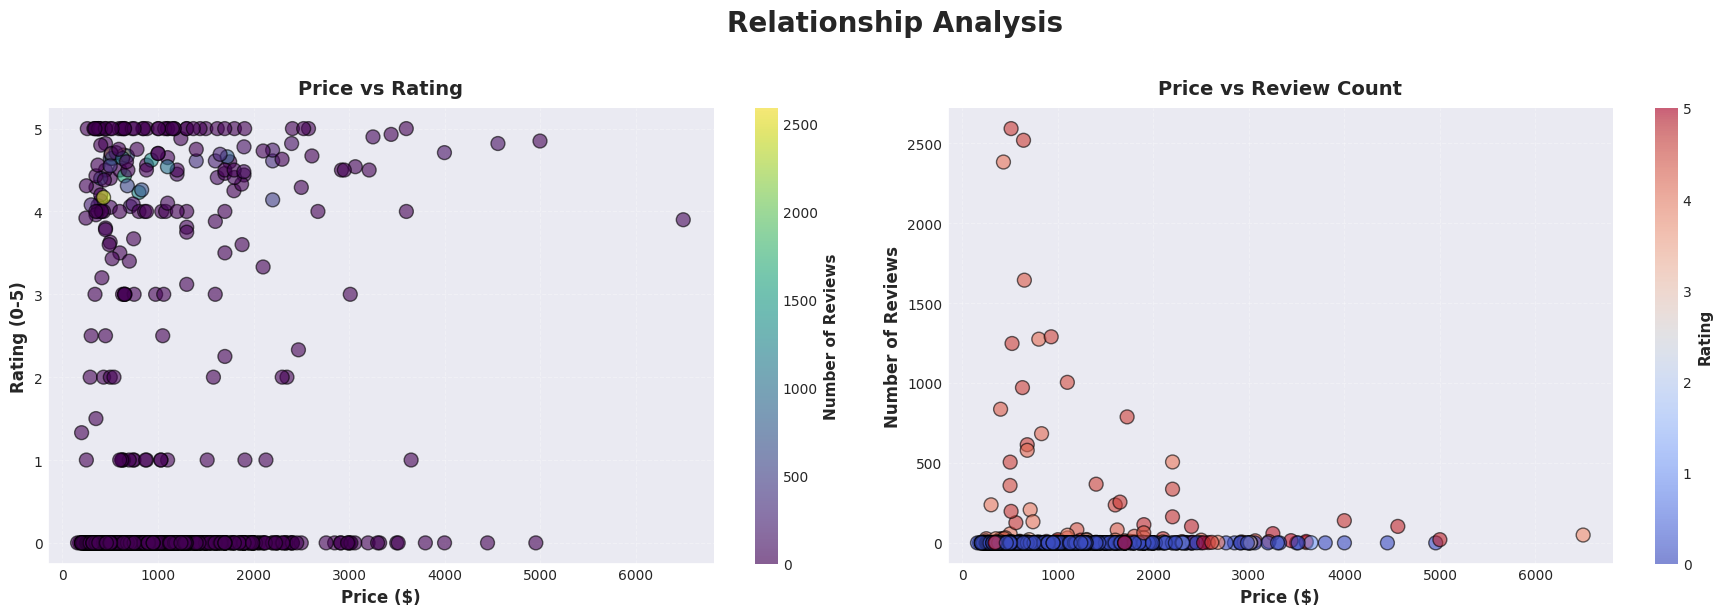

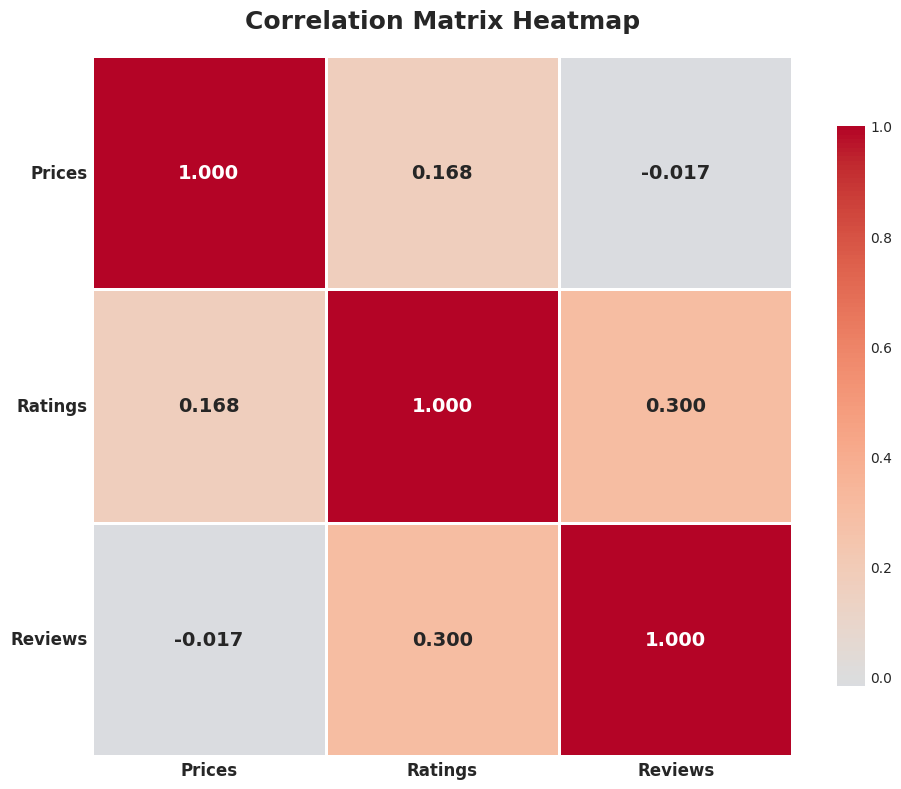

/home/dem/workspace/webscraping-with-python/src/visualizer.py:238: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/home/dem/workspace/webscraping-with-python/src/visualizer.py:238: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/home/dem/workspace/webscraping-with-python/src/visualizer.py:238: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/home/dem/workspace/webscraping-with-python/src/visualizer.py:238: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/home/dem/workspace/webscraping-with-python/src/visualizer.py:238: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/home/dem/.local/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mo

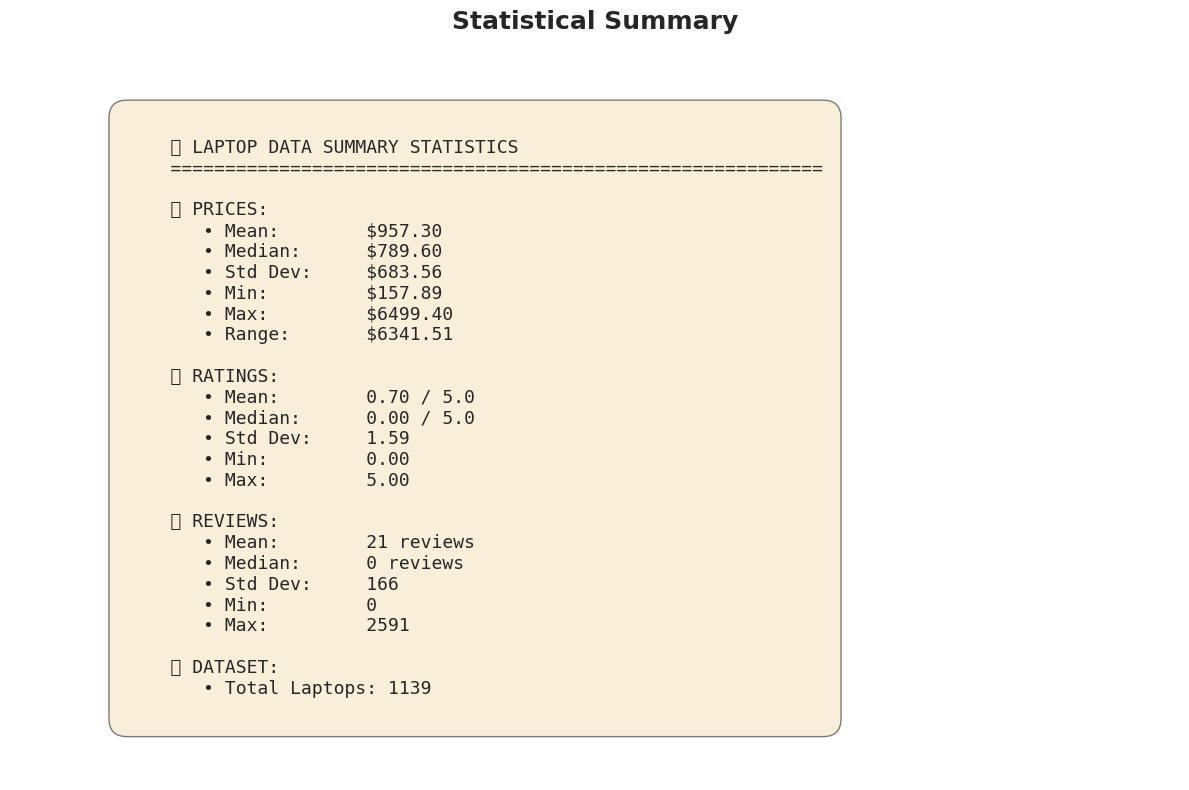

2025-12-10 13:27:12 | SUCCESS  | src.visualizer:visualize_data:263 - ✨ All visualizations created successfully!


In [16]:
# Use the complete visualization function
logger.info("Running complete visualization pipeline...")
visualize_data(df_clean)

# Remove outliers

In [17]:

def remove_outliers_iqr(df, column):
    """
    Removes outliers from a specified column of a DataFrame using the 1.5 * IQR rule.
    Returns a new DataFrame with outliers filtered out.
    """
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Define bounds for outlier detection (1.5 * IQR)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the DataFrame: keep rows where the column value is within the bounds
    mask = (df[column] >= lower_bound) & (df[column] <= upper_bound)
    return df[mask]



In [18]:
# --- Application Logic ---

# Assuming your DataFrame is named 'df'
df_cleaned = df_clean.copy() 

# List of columns to check for outliers
columns_to_check = ['prices']

for col in columns_to_check:
    # Print the bounds for logging/checking (optional)
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print(f"Processing column: {col}")
    print(f"  Bounds: ({lower_bound:.2f}, {upper_bound:.2f})")
    
# Apply the filtering function and update the DataFrame
df_cleaned = remove_outliers_iqr(df_cleaned, col)
print(df_cleaned.head())

Processing column: prices
  Bounds: (-578.07, 2267.45)
   Unnamed: 0                                            laptops  prices  \
0           0  Dell Inspiron 15 15.6" Touchscreen Laptop (Int...  500.39   
1           1  ASUS Vivobook Go 15 15.6" Laptop - Mixed Black...  400.37   
2           2  Acer Aspire Lite 15.6" Laptop - Silver (Intel ...  350.39   
3           3  Lenovo IdeaPad Slim 3i 15.3" Laptop - Luna Gre...  450.39   
4           4  Acer Aspire Go 15.6" Laptop - Iron (Intel Core...  500.39   

   ratings  votes  
0     4.64  505.0  
1     4.13   23.0  
2     4.29    7.0  
3     4.82   11.0  
4     4.40    5.0  


2025-12-10 13:27:12 | INFO     | __main__:<module>:2 - Running complete visualization pipeline...
2025-12-10 13:27:12 | INFO     | src.visualizer:visualize_data:249 - ====================================================================================================
2025-12-10 13:27:12 | INFO     | src.visualizer:visualize_data:250 - 📊 CREATING BEAUTIFUL VISUALIZATIONS...
2025-12-10 13:27:12 | INFO     | src.visualizer:visualize_data:251 - ====================================================================================================
2025-12-10 13:27:12 | INFO     | src.visualizer:visualize_data:252 - Descriptive statistic measures of the data
2025-12-10 13:27:12 | INFO     | src.visualizer:visualize_data:253 - 
            prices      ratings        votes
count  1085.000000  1085.000000  1085.000000
mean    851.410608     0.638111    21.452535
std     468.948690     1.531139   170.392154
min     157.890000     0.000000     0.000000
25%     469.000000     0.000000     0.000000
50

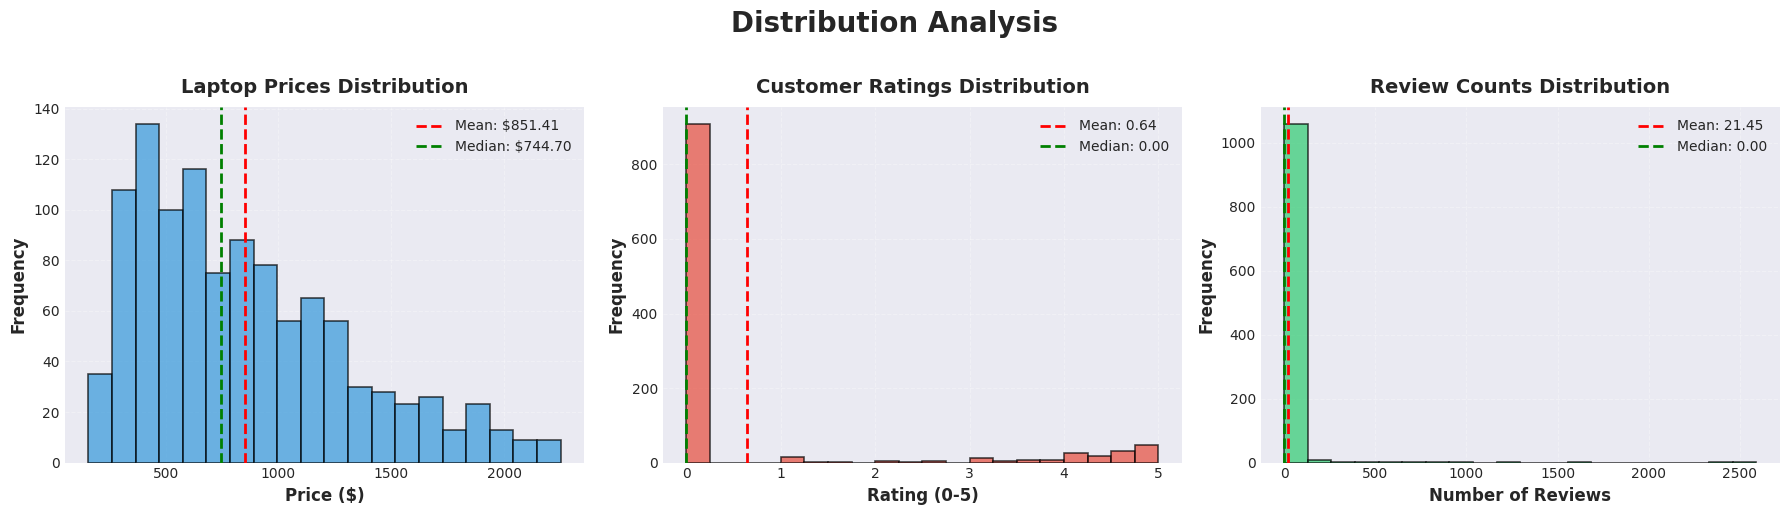

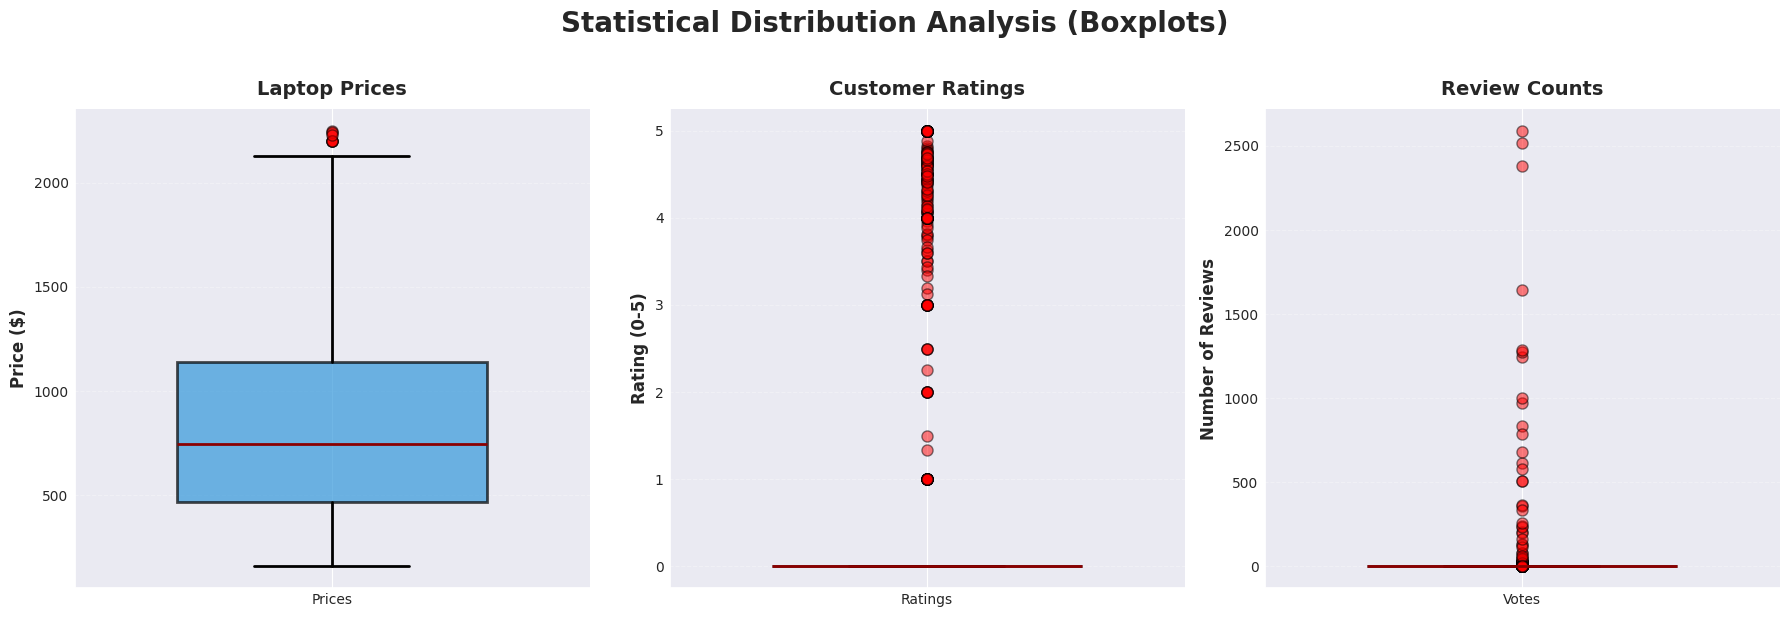

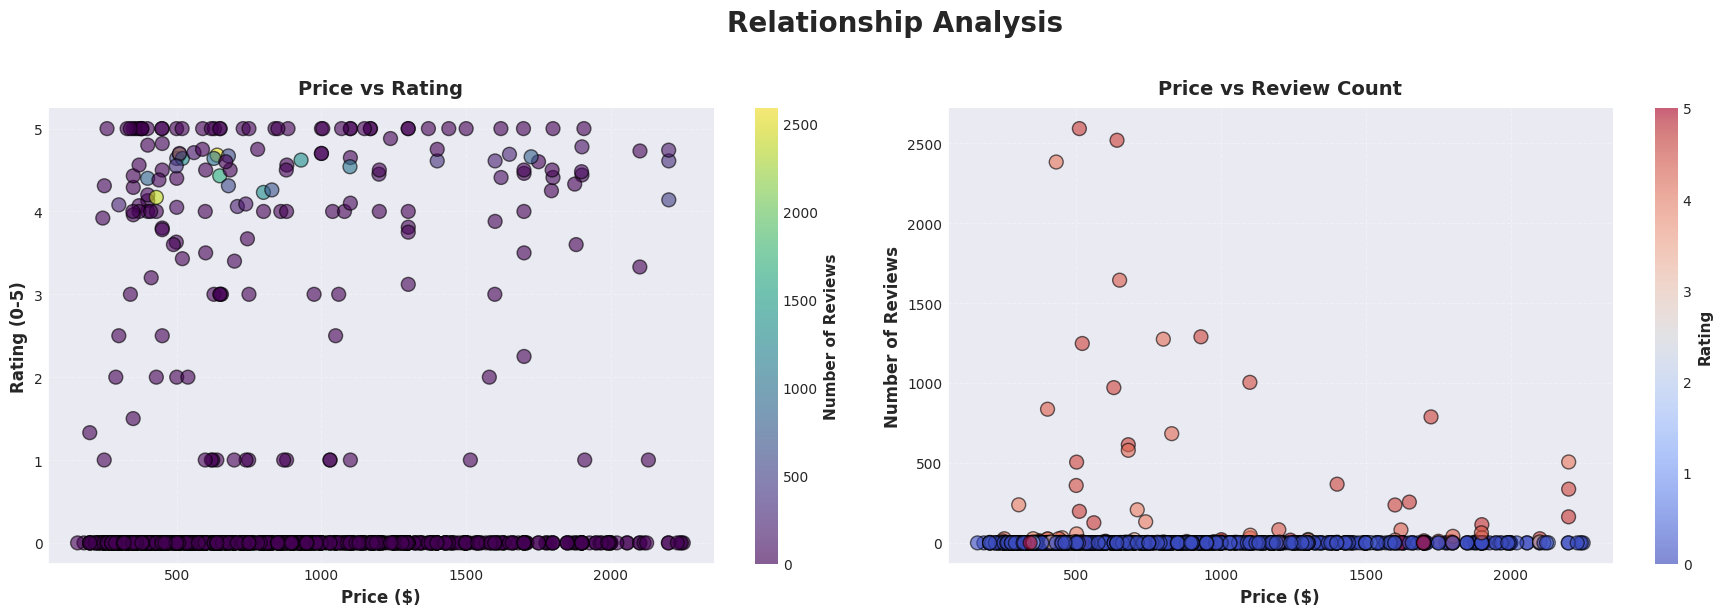

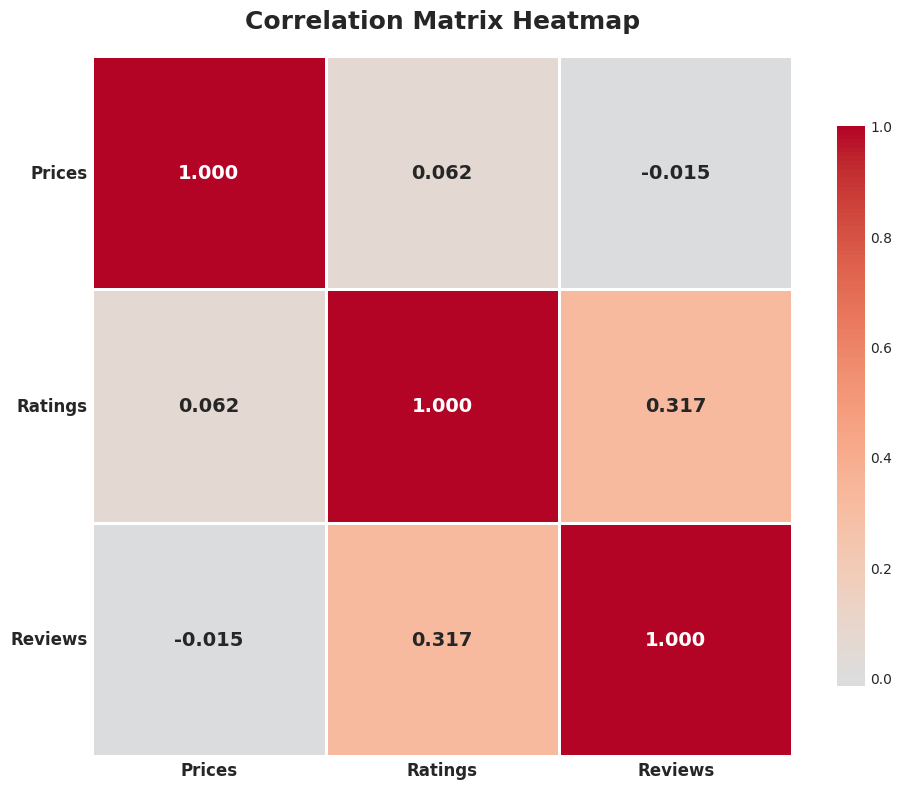

/home/dem/workspace/webscraping-with-python/src/visualizer.py:238: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/home/dem/workspace/webscraping-with-python/src/visualizer.py:238: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/home/dem/workspace/webscraping-with-python/src/visualizer.py:238: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/home/dem/workspace/webscraping-with-python/src/visualizer.py:238: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/home/dem/workspace/webscraping-with-python/src/visualizer.py:238: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/home/dem/.local/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mo

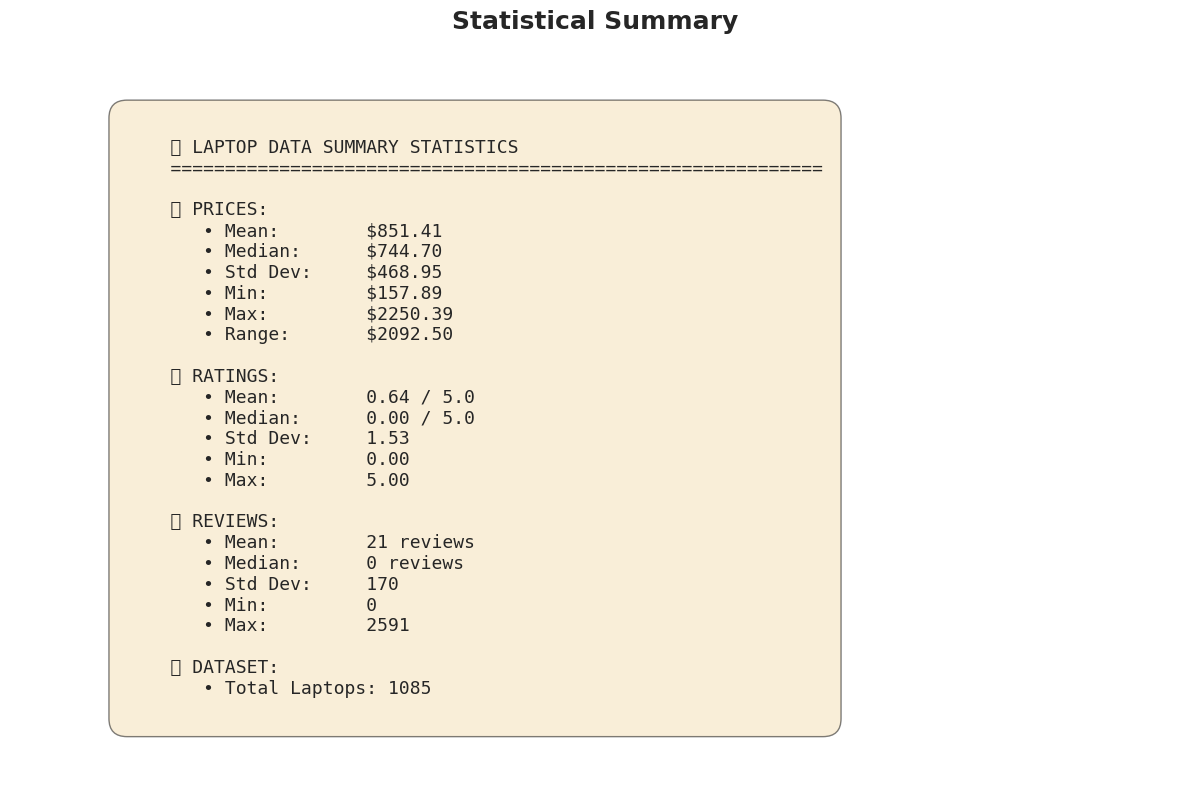

2025-12-10 13:27:13 | SUCCESS  | src.visualizer:visualize_data:263 - ✨ All visualizations created successfully!


In [19]:
# Use the complete visualization function
logger.info("Running complete visualization pipeline...")
visualize_data(df_cleaned)

## Custom Analysis

Perform additional custom analysis on the data.

In [20]:
# Price distribution by rating category
logger.info("Analyzing price by rating category...")

# Categorize ratings
df_clean['rating_category'] = pd.cut(
    df_clean['ratings'], 
    bins=[0, 70, 85, 95, 100],
    labels=['Low (0-70)', 'Medium (70-85)', 'High (85-95)', 'Excellent (95-100)']
)

# Group by category and show mean price
price_by_rating = df_clean.groupby('rating_category')['prices'].agg(['mean', 'median', 'count'])
print("\nPrice Statistics by Rating Category:")
print(price_by_rating)

2025-12-10 13:27:13 | INFO     | __main__:<module>:2 - Analyzing price by rating category...

Price Statistics by Rating Category:
                          mean  median  count
rating_category                              
Low (0-70)          1195.85801  869.99    201
Medium (70-85)             NaN     NaN      0
High (85-95)               NaN     NaN      0
Excellent (95-100)         NaN     NaN      0


/tmp/ipykernel_332190/1399713687.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_by_rating = df_clean.groupby('rating_category')['prices'].agg(['mean', 'median', 'count'])


<Figure size 1200x600 with 0 Axes>

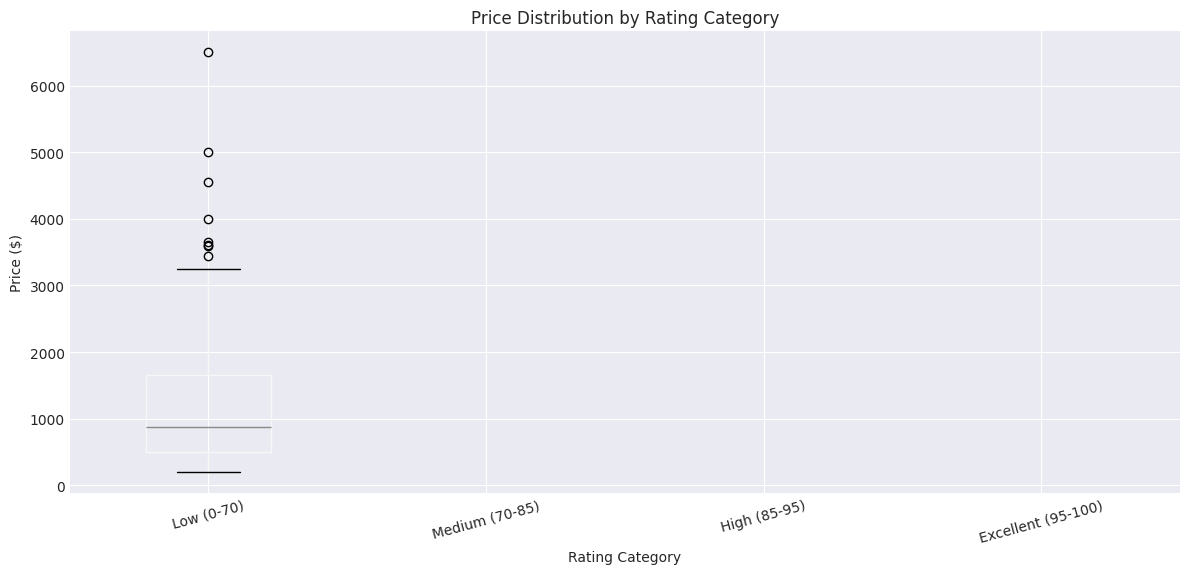

In [21]:
# Visualize price vs rating category
plt.figure(figsize=(12, 6))
df_clean.boxplot(column='prices', by='rating_category', figsize=(12, 6))
plt.title('Price Distribution by Rating Category')
plt.suptitle('')  # Remove automatic title
plt.ylabel('Price ($)')
plt.xlabel('Rating Category')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:

1. **Modular Code Structure**: Using functions from `src/` modules
2. **Loguru Logging**: Professional logging instead of print statements
3. **Data Pipeline**: Configuration → Scraping → Cleaning → Visualization
4. **Data Analysis**: Descriptive statistics and custom insights
5. **Visualization**: Histograms, boxplots, and custom charts

### Next Steps:

- Explore different RAM sizes and price ranges
- Add more sophisticated analysis (correlation, regression)
- Create a dashboard for interactive exploration
- Schedule regular scraping to track price trends over time

In [22]:
logger.success("Tutorial complete! You've learned how to use Selenium-based webscraping with the updated modules.")

2025-12-10 13:27:13 | SUCCESS  | __main__:<module>:1 - Tutorial complete! You've learned how to use Selenium-based webscraping with the updated modules.
